In [3]:
#all my fave imports in case I need them later
import numpy as np
from scipy.optimize import *
from scipy.integrate import *
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore') #living dangerously

### Problem 1A.)

In Problem 1A, we look to convert data given in the assignment statement (as can be viewed at `ChemE5440_ PRELIM_assignment.pdf`).  

Evidently, mRNA/cell must be converted to nmol/gDW.  To do this, the following scheme and givens are used:

$$ \beta = <m_c> \hat N_c V \hspace{20mm} V=1mL \hspace{20mm} \hat N_c = 1*10^8 cells/mL$$

This means that in the sample, there is $<n>*10^8$ copies of mRNA.  However, there are also $10^8$ cells, and as such, the total mass (in gDW) proportionally increases. 

To find $<m_c>$, an internet resource, BioNumbers was used.  The total mass per cell was found to be $<m_c>=2.8*10^{-13} gDW/cell$.  The source can be found here: https://bionumbers.hms.harvard.edu/bionumber.aspx?&id=103905&ver=13


$$ (<n> \frac{mRNA}{Cell})*(\frac{1 mol}{6.022*10^{23} mRNA})*(\frac{1*10^9 nmol}{1 mol})*(\frac{Cell}{2.8*10^{-13} gDW})$$

The conversion is used on all three columns with mRNA concentration/cell.

In [4]:
#we look to store the data in a single data matrix
data= np.matrix([[0,19,18,20],    # data in column form [IPTG(mM) , <n>(mRNA/cell) , low(mRNA/cell) , high(mRNA/cell)]
                 [0.0005,21,17,26],
                 [0.005,41,37,44],
                 [0.012,67,65,69],
                 [0.053,86,84,88],
                 [0.216,93,91,95],
                 [1,93,92,94]])
dataNew=data #doing it like this because isn't vectorized computation fun :)
dataNew[:,1:]=np.multiply(data[:,1:],0.0059306) #value obtained in conversion above for mRNA/cell --> nmol/gDW 
print(dataNew) 

[[0.000000e+00 1.126814e-01 1.067508e-01 1.186120e-01]
 [5.000000e-04 1.245426e-01 1.008202e-01 1.541956e-01]
 [5.000000e-03 2.431546e-01 2.194322e-01 2.609464e-01]
 [1.200000e-02 3.973502e-01 3.854890e-01 4.092114e-01]
 [5.300000e-02 5.100316e-01 4.981704e-01 5.218928e-01]
 [2.160000e-01 5.515458e-01 5.396846e-01 5.634070e-01]
 [1.000000e+00 5.515458e-01 5.456152e-01 5.574764e-01]]


The second column gives the values of $<n>$ in units of nmol/gDW.  They range from 0.11 nmol/gDW for IPTG=0 to 0.55 nmol/gDW for IPTG=1mM.

### Problem 1B.)

Starting with the balance given in the problem:

$$ \dot m_i = r_{X,i} \bar \mu_i - (\mu + \theta_{m,i})m_i$$

where $\dot m_i$ is the transient derivative of mRNA concentration, $r_{X,i} \bar \mu_i$ represents the rate of production for mRNA corresponding to gene i, and $m_i$ describes the amount of mRNA for gene i.  The $\mu$ and $\theta{m,i}$ terms are constants accounting for dilution and degradation.  Often, we may see an additional parameter on the right side of the equation above, $\lambda_i$ representing the unregulated rate of transcription or 'leak'.  However, in this case, for simplicity, we ignore this term.

Proceeding, at psuedo-steady-state, the time derivative term, $\dot m_i = 0$.  Additionally, $m_i$ can be turned into $m^*$ by definition as it is now the concentration at psuedo-steady-state.  Simple algebra yields:

$$\frac{r_{X,i} \bar \mu_i}{\mu + \theta_{m,i}} =m_i^*$$

Writing this more explicitly gives as a product of two terms and dropping the i subscript gives,

$$ m^* = (\frac{r_X}{\mu+\theta_{m}})(\bar \mu) \hspace{40mm}\frac{r_X}{\mu+\theta_{m}}=\kappa_X \hspace{20mm} \bar \mu = promoter$$

where $\frac{r_X}{\mu+\theta_{m}}=\kappa_X$ is a gain function, and $\bar \mu$ represents the promoter function.  These two functions are subsequently examined.

For futher examination, course notes on transcription were used (see `problem1_referenceNotes.pdf` on GitHub repo).

From the class notes, we derived an expression for $r_{X}$ in terms of $G$ and other constants as EQ (26).  Algebraically manipulation of the equation easily shows that:

$$ \kappa_X =f(G,\theta)$$

For a complete derivation, refer to `problem1_referenceNotes.pdf`, so I do not need to repeat it here.

Thus, $\kappa_X$ is a function of G and other constants.  Similarly from the notes we find:

$$ \bar \mu =\frac{W_1 + W_2 f_I}{1+W_1+W_2f_I}  \hspace{20mm} f_I= \frac{I^n}{K^n+I^n}$$

$$ \bar \mu(I,\kappa) =\frac{W_1 + W_2 (\frac{I^n}{K^n+I^n})}{1+W_1+W_2 (\frac{I^n}{K^n+I^n})} $$

Evidently, $\mu$ is a function of I and constants n, K, W1, and W2.  (Note that I here is IPTG)

### Problem 1C.)

To create such a model, parameters for the system must be obtained.  

First, we note that the only manipulated variable for the system is IPTG concentration.  Thus the gain function, $\kappa_X$ is a constant.  Thus, the model has functional form:

$$m^*=\kappa_X \bar \mu(I,\kappa)=\kappa_X \frac{W_1 + W_2 (\frac{I^n}{K^n+I^n})}{1+W_1+W_2 (\frac{I^n}{K^n+I^n})}$$

Thus, the variable parameters to tune for fitting are $W_1, W_2, \kappa_X, K, n$.  While it would be plausible to simply use least squares right away, that would miss alot of physical understanding of the system.  Instead, we will attempt to define some of these constant values to give some intuition to the fit (this also helps constrain the optimzation).

As defined in the problem statement, $\bar \mu$ is always in range $[0,1]$.  At sufficiently high IPTG, the system for $\bar \mu$ saturates and equals 1.  In this case, $m^*=\kappa_X (1) = \kappa_X$.  Consulting the data provided in Table 1 from Golding (using converted form as discussed in part a), it is evident that $<n>$ is saturating as the last two values are equivalent despite a massive jump in IPTG concentration.

Thus, $\kappa_X=0.5515 nmol/gDW$. 

Noting that previously defined $f_I$ works as an activation function, for $I=0, f_I=0$ so $\bar \mu=\frac{W_1}{1+W_1}$

Once again looking to the Golding data @ IPTG=0 (converted still of course for $<n>$), $W_1$ is solved for. 

$$m^*(@I=0)=\kappa_X \frac{W_1}{1+W_1}=0.11268=0.5515\frac{W_1}{1+W_1} \hspace{20mm} W_1=0.25678$$




In [ ]:
#implementing least squares modeling
K_X=0.5515458; W1=0.2567795   #as previously found


def residuals(variables,IPTG,data): #finds residual error for data taken at IPTG values for given model parameters
    """
    residual finds error between data @ values of IPTG for a model previously defined
    variables: [W2,K,n]
    """
    W2=variables[0]
    K=variables[1]
    n=variables[2]
    
    fI=(np.power(IPTG,n))/(np.power(K,n)+np.power(IPTG,n))
    predict=K_X * (W1+W2*fI)/(1+W1+W2*fI)
    
    return (data-predict) #discrepancy between model and real data

IPTG=dataNew[:,0].ravel()
mStar=dataNew[:,1].ravel()

variables=np.array([1,1,1]) #our initial guess for parameters
out=leastsq(residuals,variables,args=(IPTG,mStar))
print(out)

#### For whatever, reason, I could not make LSQ work in Python so I had to do it in excel instead.  See attatched excel workbook `prelim_LSQ_implementation.xlsx` for work showing the regression.  I don't know why the above cell throws an error, if you have any ideas let me know.

#### Table of Values:

$<m_c>=2.38*10^{-13} gDW \hspace{20mm}$ : BioNumbers- 103905

$W_1 = 0.25678 \hspace{45mm}$ : Calculation Above

$\kappa_X=0.5515 nmol/gDW \hspace{27mm}$ : Calculation Above 

$n=1.517 \hspace{53mm}$ : LSQ

$W_2 = 187.52 \hspace{47mm}$ : LSQ

$K = 0.22755 \hspace{47mm}$ : LSQ

$G_i = 2 \hspace{58mm}$ : Given

$\tau_{1/2,mRNA}=40 min \hspace{37mm}$ : Given

$V=1mL \hspace{53mm} $ : Given

It is also quite satisfying to note that the parameter values are quite similar to those found during lecture, where $n=1.5, K=0.3, W_1=0.26, W_2=300$.

### Problem 1D.)

Using LSQ values and other previously found model parameters for the model (see `prelim_LSQ_implementation.xlsx`)

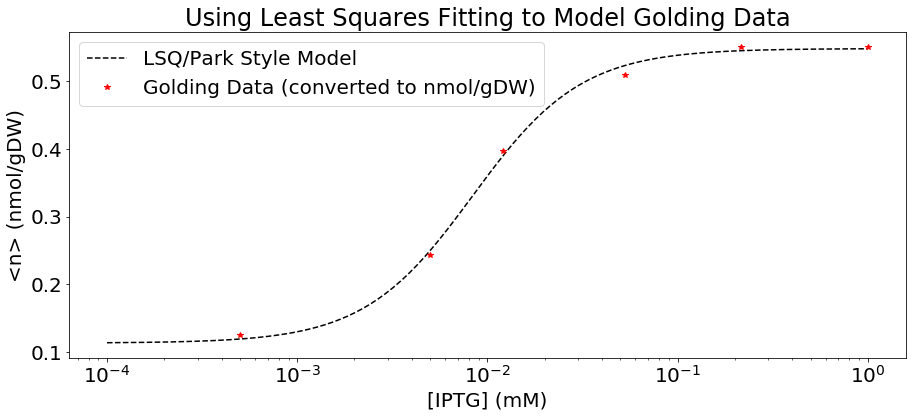

In [5]:
IPTGtight=np.logspace(-4,0,200)
IPTG=dataNew[:,0]
mStar=dataNew[:,1]

n=1.517; K=0.22755; W2=187.52; #parameters from LSQ
W1=0.25678; KX=0.5515; #values which came from reasoning

fI=(np.power(IPTGtight,n))/(np.power(K,n)+np.power(IPTGtight,n))
model=KX * (W1+W2*fI)/(1+W1+W2*fI)

plt.rcParams["figure.figsize"] = (15,6) 
plt.rcParams.update({'font.size': 20})
plt.plot(IPTGtight,model,'k--',label='LSQ/Park Style Model');
plt.plot(IPTG,mStar,'r*',label='Golding Data (converted to nmol/gDW)');
plt.xscale('log');
plt.xlabel('[IPTG] (mM)');
plt.ylabel('<n> (nmol/gDW)');
plt.legend(loc='best');
plt.title('Using Least Squares Fitting to Model Golding Data');

Overall, I would say this is a very good fit to the data.  The model certainly has the right shape for the data.  The $f_I$ 'activation' function is modified most heavily at low values of I by the addition terms, which helps to smooth the value out to a non-zero initial point.